# 🧬 Huntington Disease Prediction Using Machine Learning 🧠

## 📌 Introduction
Huntington’s Disease (HD) is a progressive neurodegenerative disorder caused by the expansion of **CAG repeats** in the **HTT gene**. Early detection and staging of the disease are crucial for research and potential therapeutic interventions.

In this notebook, I build a **RandomForestClassifier** to predict disease progression stages based on **genetic, clinical, and functional biomarkers**.

## 📊 Dataset Overview
The dataset used in this analysis is sourced from **[Kaggle](https://www.kaggle.com/datasets/rajmohnani12/huntington-disease-dataset/data)** and consists of **48,536 patient records** with **21 features**, including:
- 🏥 **Demographic information** → Age, Sex, Family History
- 🧬 **Genetic Markers** → HTT CAG Repeat Length, Gene Mutation Type
- 🩺 **Clinical Symptoms** → Motor Symptoms, Cognitive Decline, Chorea Score
- 🧠 **Functional Measures** → Brain Volume Loss, Functional Capacity

The **target variable** for prediction is **Disease_Stage**, which categorizes patients into:
🔵 **Pre-Symptomatic** | 🟢 **Early** | 🟡 **Middle** | 🔴 **Late**

---

## 🔧 Data Cleaning & Preprocessing
To prepare the dataset for modeling, we applied the following transformations:

✔ **Dropped Non-Informative Columns**
&nbsp;&nbsp;&nbsp;&nbsp; Removed `Patient_ID`, `Random_Protein_Sequence`, and `Random_Gene_Sequence` as they do not contribute to prediction.

✔ **Handled Missing Data**
&nbsp;&nbsp;&nbsp;&nbsp; Using SimpleImputer and median for missing values in CognitiveDecline

✔ **Encoded Categorical Features**
&nbsp;&nbsp;&nbsp;&nbsp; - `Disease_Stage` was **ordinally encoded** to preserve its progression order (`Pre-Symptomatic → 0`, `Early → 1`, `Middle → 2`, `Late → 3`).
&nbsp;&nbsp;&nbsp;&nbsp; - Other categorical variables (`Sex`, `Family_History`, `Motor_Symptoms`, etc.) were **one-hot encoded**.

✔ **Feature Scaling**
&nbsp;&nbsp;&nbsp;&nbsp; Standardized numerical features (`Age`, `HTT_CAG_Repeat_Length`, `Brain_Volume_Loss`, etc.) using **StandardScaler** to improve model performance.

---

## 🤖 Modeling Approach
We trained a **RandomForestClassifier** to classify patients into one of the four disease stages. The model pipeline includes:
✅ **Feature Preprocessing** → One-Hot Encoding, Standard Scaling
✅ **Random Forest Model Training**
✅ **Hyperparameter Optimization using RandomizedSearchCV**

We evaluate model performance using:
- 📊 **Cross-Validation Accuracy**
- 🏆 **Classification Report (Precision, Recall, F1-score)**
- 🔍 **Feature Importance Analysis**

---
Let’s get started! 🧬✨

In [242]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [232]:
# Load the data
Huntington_Data_Path = "/Users/Nia/PycharmProjects/LearningML_1/datasets/bioinformatics/Huntington_Disease_Dataset.csv"
Huntington_Data = pd.read_csv(Kidney_Stone_Data_Path)

# Let's take a quick look at the data structure

In [233]:
Huntington_Data.head()

,Patient_ID,Age,Sex,Family_History,HTT_CAG_Repeat_Length,Motor_Symptoms,Cognitive_Decline,Chorea_Score,Brain_Volume_Loss,Functional_Capacity,...,HTT_Gene_Expression_Level,Protein_Aggregation_Level,Random_Protein_Sequence,Random_Gene_Sequence,Disease_Stage,Gene/Factor,Chromosome_Location,Function,Effect,Category
0,b2a49170-8561-4665-9371-2240b55dd87a,31,Male,No,67,Moderate,Severe,8.80,3.20,94,...,1.67,0.58,DAHKIRSPMRVGPHYYAQCDNNDTGSDKEHWLKTEAAPMTMDRTVESSSS,GCCAGCAGCGCCCGAGCGTATGAGGTATATGGATTGGACATTGGGCCTCATCTATAAATTGGAATTTCGAACTGCTACACCCTAACTTGCGTATGTATTG,Middle,HTT,4p16.3,CAG Trinucleotide Repeat Expansion,Neurodegeneration,Primary Cause
1,f5fae45d-8718-41c4-a957-6928f79f3c8e,33,Female,Yes,38,Severe,Moderate,3.24,5.98,50,...,0.18,0.30,PANGFWYHNCLRFWNIPPYVMEGFPLADITEVHKWRVSGFMCWETQIRDH,AGTTTTCAGTGAGACTCTTCCCCAAAAGCCTCCACTACGACAGTGTCACTACGTGTGGGATGTCTGTCCGCTGCTACCATCGCCATCGTTTGAGGACTTT,Pre-Symptomatic,HTT,4p16.3,CAG Trinucleotide Repeat Expansion,Neurodegeneration,Primary Cause
2,66ab0567-050b-4d56-9ec4-b676309899a6,69,Male,Yes,37,Severe,Moderate,1.01,2.82,69,...,0.90,1.04,NWHEGHGASTWKATMVAWCLMVQHAVTWKEGNTRCREMSCMNFTQLTWFR,TATACCACCAGTGGGAAGAGTAACGATTTTGGAGCGCCCCGAGTCCCTCGGCCTCGGCTGCCTAGCGAGTTGCCCAACTGAACAGAGCAATCGATCTCGG,Early,MSH3,5q14.1,Mismatch Repair,CAG Repeat Expansion,Trans-acting Modifier
3,996a48e4-e841-418f-a539-5a7a86cd815d,66,Male,Yes,50,Mild,Severe,3.21,6.77,76,...,1.16,1.87,KCVQYIQATQMLVQSWGQRNPIMQSSEPDRAHDYESGTPKTYTYMLVDCC,GCGCGACCGACCAAAGGACCCATGGTGGTGATCTGTCATTGGATTCATCTACAACCACCTGTGGGTTAATCTTAGCTGTGTTTCTTTTCTGTCCGTCCAG,Pre-Symptomatic,MSH3,5q14.1,Mismatch Repair,CAG Repeat Expansion,Trans-acting Modifier
4,d45c7ca8-7125-4aaa-8018-5bbc60d35a1f,43,Female,Yes,48,Moderate,Mild,2.31,7.53,70,...,1.85,2.94,DQPGNMTRQNKNHCMWRAKRPTKHPGHKPGEIDKEKSEQNDADSSAYWDW,GGGACCGCGGTTCTAGAAGAGAGGTTCTCTGACCGCCGAAGGATTCGATAGATTCGGGCGACTTCGACACAGTACATTATAGGAAACACGCTTAGAAAGA,Late,HTT (Somatic Expansion),4p16.3,CAG Repeat Instability,Faster Disease Onset,Cis-acting Modifier


In [234]:
Huntington_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48536 entries, 0 to 48535
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient_ID                 48536 non-null  object 
 1   Age                        48536 non-null  int64  
 2   Sex                        48536 non-null  object 
 3   Family_History             48536 non-null  object 
 4   HTT_CAG_Repeat_Length      48536 non-null  int64  
 5   Motor_Symptoms             48536 non-null  object 
 6   Cognitive_Decline          36417 non-null  object 
 7   Chorea_Score               48536 non-null  float64
 8   Brain_Volume_Loss          48536 non-null  float64
 9   Functional_Capacity        48536 non-null  int64  
 10  Gene_Mutation_Type         48536 non-null  object 
 11  HTT_Gene_Expression_Level  48536 non-null  float64
 12  Protein_Aggregation_Level  48536 non-null  float64
 13  Random_Protein_Sequence    48536 non-null  obj

In [235]:
Huntington_Data.describe()

,Age,HTT_CAG_Repeat_Length,Chorea_Score,Brain_Volume_Loss,Functional_Capacity,HTT_Gene_Expression_Level,Protein_Aggregation_Level
count,48536.000000,48536.000000,48536.000000,48536.000000,48536.000000,48536.000000,48536.000000
mean,55.070566,57.516606,4.994399,5.261030,50.354829,1.301060,2.546519
std,14.762154,13.264153,2.897327,1.872995,29.189697,0.691657,1.414745
min,30.000000,35.000000,0.000000,2.000000,0.000000,0.100000,0.100000
25%,42.000000,46.000000,2.480000,3.640000,25.000000,0.700000,1.330000
50%,55.000000,58.000000,4.980000,5.280000,50.000000,1.300000,2.540000
75%,68.000000,69.000000,7.500000,6.880000,76.000000,1.900000,3.770000
max,80.000000,80.000000,10.000000,8.500000,100.000000,2.500000,5.000000


In [236]:
Huntington_Data["Disease_Stage"].value_counts()

Disease_Stage
Middle             12289
Pre-Symptomatic    12191
Early              12032
Late               12024
Name: count, dtype: int64

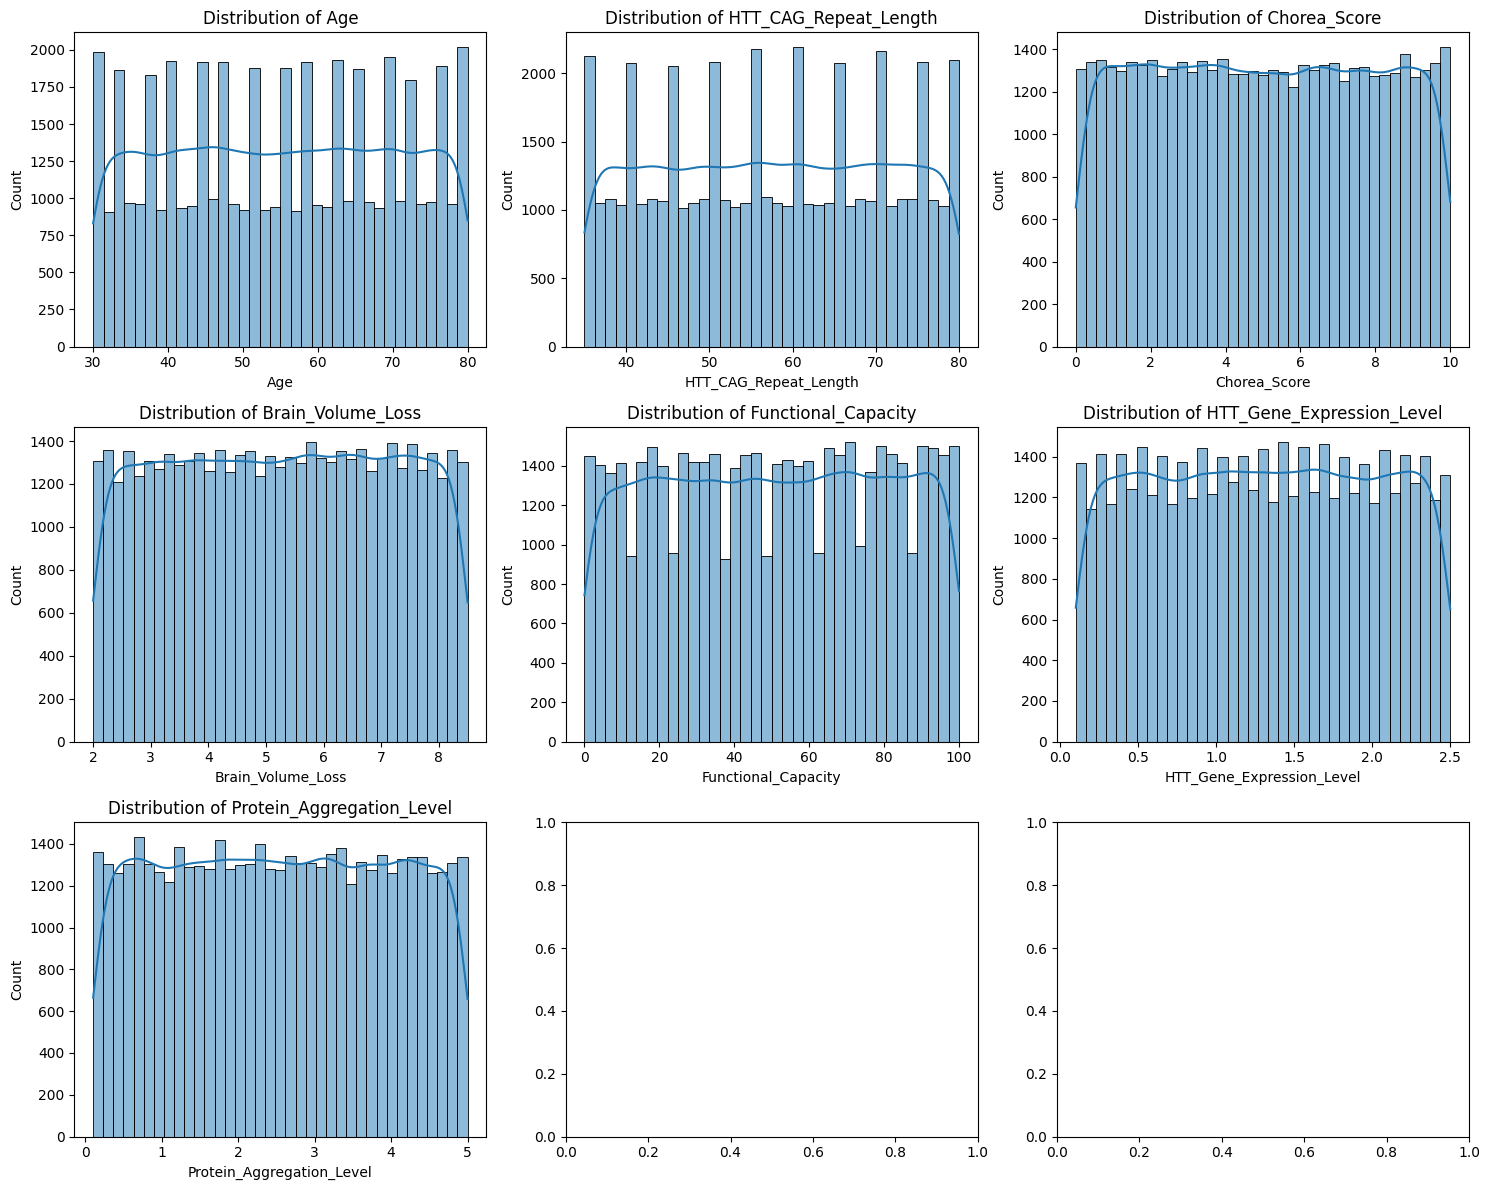

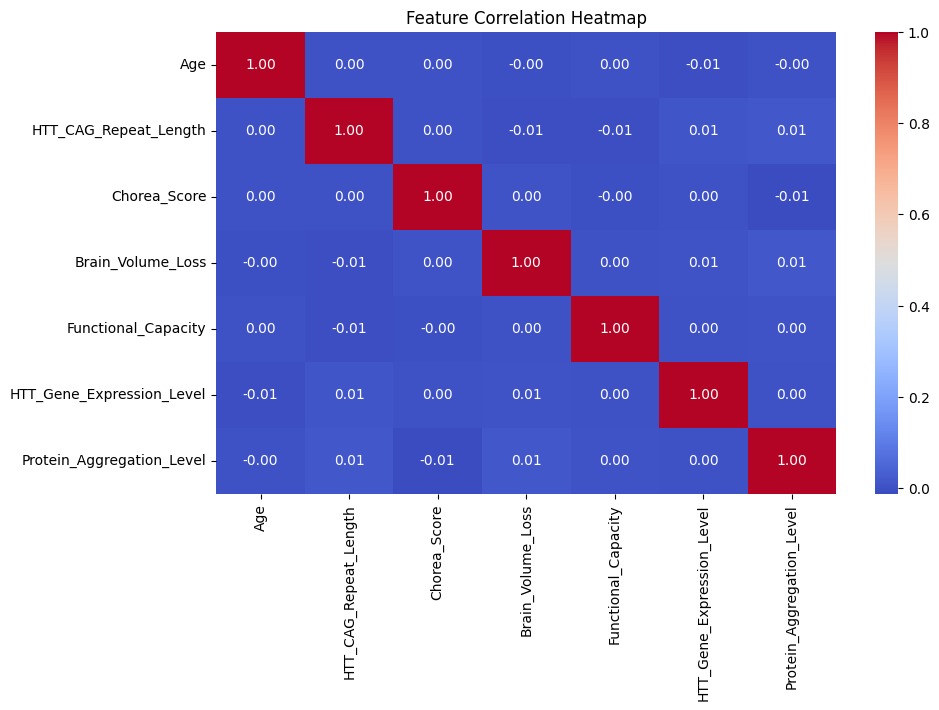

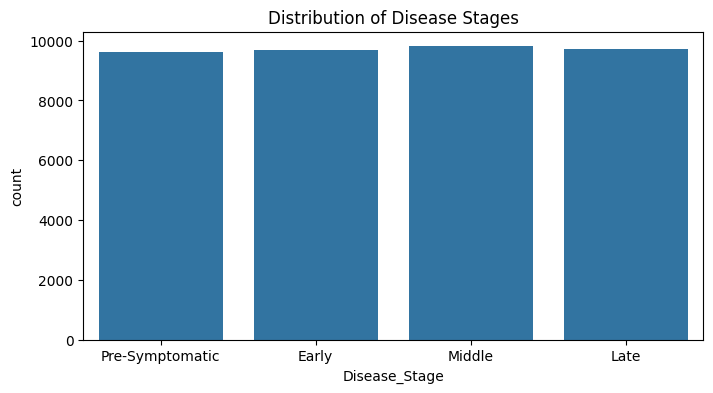

In [244]:
# Let's plot the numerical features

numerical_features = ["Age", "HTT_CAG_Repeat_Length", "Chorea_Score", "Brain_Volume_Loss",
                      "Functional_Capacity", "HTT_Gene_Expression_Level", "Protein_Aggregation_Level"]

# Plot Feature Distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(Huntington_Data[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = Huntington_Data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Bar Plot for Disease Stage Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=Huntington_Data_labels)
plt.xticks(ticks=[0, 1, 2, 3], labels=["Pre-Symptomatic", "Early", "Middle", "Late"])
plt.title("Distribution of Disease Stages")
plt.show()

In [238]:
# Let's drop non-informative columns
columns_to_drop = ["Patient_ID", "Random_Protein_Sequence", "Random_Gene_Sequence"]
Huntington_Data.drop(columns=columns_to_drop, inplace=True)



# Create a Test Set

In [222]:
Huntington_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48536 entries, 0 to 48535
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        48536 non-null  int64  
 1   Sex                        48536 non-null  object 
 2   Family_History             48536 non-null  object 
 3   HTT_CAG_Repeat_Length      48536 non-null  int64  
 4   Motor_Symptoms             48536 non-null  object 
 5   Cognitive_Decline          36417 non-null  object 
 6   Chorea_Score               48536 non-null  float64
 7   Brain_Volume_Loss          48536 non-null  float64
 8   Functional_Capacity        48536 non-null  int64  
 9   Gene_Mutation_Type         48536 non-null  object 
 10  HTT_Gene_Expression_Level  48536 non-null  float64
 11  Protein_Aggregation_Level  48536 non-null  float64
 12  Disease_Stage              48536 non-null  object 
 13  Gene/Factor                48536 non-null  obj

In [223]:
# The stratified sampling keeps the same ratio of women/men
strat_train_set, strat_test_set = train_test_split(
Huntington_Data, test_size=0.2, stratify=Huntington_Data["Sex"], random_state=42)

In [224]:
# Let's make sure this is actually the case

def gender_proportions(data):
    return data["Sex"].value_counts() / len(data)

train_set, test_set = train_test_split(Huntington_Data, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": gender_proportions(Huntington_Data),
    "Stratified %": gender_proportions(strat_test_set),
    "Random %": gender_proportions(test_set),
}).sort_index()
compare_props.index.name = "Gender Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)

(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Gender Category,,,,,
Female,50.0,50.0,49.66,-0.01,-0.69
Male,50.0,50.0,50.34,0.01,0.69


# Data Cleaning and Preprocessing

In [225]:
# Encode Disease_Stage as an ordinal variable
disease_stage_order = [["Pre-Symptomatic", "Early", "Middle", "Late"]]
ordinal_encoder = OrdinalEncoder(categories=disease_stage_order)
Huntington_Data["Disease_Stage"] = ordinal_encoder.fit_transform(Huntington_Data[["Disease_Stage"]]).astype(int)

In [226]:
# Transformation Pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_exclude=object)),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ])

In [227]:
# Let's first separate the target
Huntington_Data_features = strat_train_set.drop("Disease_Stage", axis=1)
Huntington_Data_labels = strat_train_set["Disease_Stage"].copy()

## Select and Train a Model and Finetune the Hyperparameters

In [228]:

# Create the full pipeline including preprocessing and model
forest_clf_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Apply feature transformations
    ("random_forest", RandomForestClassifier(random_state=42))  # Handle one-hot encoded labels
])

# Define Hyperparameter Search Space
param_distribs = {
    "random_forest__n_estimators": randint(low=50, high=300),
    "random_forest__max_features": randint(low=2, high=20),
    "random_forest__max_depth": randint(low=5, high=50)
}

# Perform Randomized Search
rnd_search = RandomizedSearchCV(
    forest_clf_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='accuracy', random_state=42
)

# Train the Model
rnd_search.fit(Huntington_Data_features, Huntington_Data_labels)

# Evaluate the Model
best_model = rnd_search.best_estimator_


In [229]:
Huntington_train_predictions = best_model.predict(Huntington_Data_features)
print(Huntington_Data_labels.tolist()[:10])
print(Huntington_train_predictions[:10])

['Early', 'Late', 'Middle', 'Early', 'Middle', 'Middle', 'Middle', 'Pre-Symptomatic', 'Pre-Symptomatic', 'Early']
['Early' 'Late' 'Middle' 'Early' 'Middle' 'Middle' 'Middle'
 'Pre-Symptomatic' 'Pre-Symptomatic' 'Early']


## Evaluate Your System on the Test Set

In [230]:
X_test = strat_test_set.drop("Disease_Stage", axis=1)
y_test = strat_test_set["Disease_Stage"].copy()

final_predictions = best_model.predict(X_test)

accuracy = best_model.score(X_test, y_test)
print(f"Best Model Accuracy: {accuracy:.4f}")

Best Model Accuracy: 0.2434
